# Parametric B&eacute;zier spline aerofoil design
## Task 1: create a parametric B&eacute;zier spline aerofoil
In this task you will write a function <code>parametric_aerofoil2(u2)</code> that creates a B&eacute;zier spline aerofoil and returns a $201\times 2$ array <code>points</code> of $x,y$ points on the aerofoil from the trailing edge, along the lower surface, round the leading edge, and back along the upper surface to the trailing edge. It should also plot the aerofoil, control points and control polygon. This is similar to Lab 3 except now the aerofoil shape should be varied by changing paramter <code>u2</code>, which controls the $x-$location of the upper surface control point $u^{(2)}_x$. All control point weightings should be equal to 1 and all other control point location coordinates should be as per Lab 3.

First you need to import relevant modules:

In [1]:
%matplotlib inline
import numpy as np #for the maths
import pylab as pl #for the plotting
from aclabtools import *
from aclab1 import * #binomial and Bezier functions

In [2]:
def parametric_aerofoil2(u2):
    
    # define the control points:
    #p = np.array(...)
    #q = np.array(...)
    p = np.array([[1.0, 0.0], [0.5, 0.08], [0.0, -0.05]])
    q = np.array([[0.0, 0.1], [u2, 0.2], [1.0, 0.0]])

    
    # weights
    zp = np.array([1, 1, 1, 1])
    zq = np.array([1, 1, 1, 1])
    
    # calculate degree
    #n = ...
    #m = ...
    n = np.float(p.shape[0])
    m = np.float(q.shape[0])
    
    # calculate connection point
    # q_start = p_end = ...
    q_start = p_end = (n/(n+m))*p[-1,:] + (m/(n+m)) *q[0,:]
    #print(q_start)
    
    # and add to control points
    pp = np.vstack([p, p_end])
    qq = np.vstack([q_start, q])
    #print(pp) 
    
    # calculate two curves 
    # lower = ...
    # upper = ...
    
    lower = rational_bezier(pp, zp)
    upper = rational_bezier(qq, zq)
    
    # and join together (removing repeat point at leading edge):
    upper = upper[1: 101]
    points = np.vstack([lower, upper])
    
    
    return points

Check that your function works:

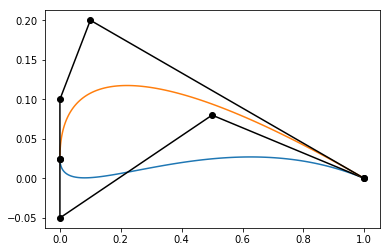

In [3]:
u2 = 0.1
points = parametric_aerofoil2(u2)

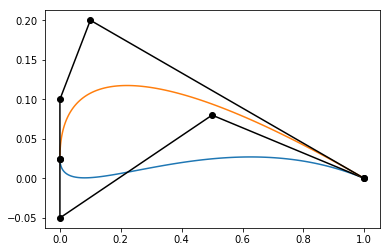

In [4]:
"""parametric_aerofoil2"""
assert np.allclose(parametric_aerofoil2(0.1)[26:29,1],[ 0.02710604,  0.02704144,  0.02691808], 0.01)

## Task 2: find the angle of attack for a given lift coefficient
You would like your race car wing to produce a specific lift, and find the design that minimises the drag for this lift. Create a function that finds the angle of attack of an aerofoil for a specified lift coefficient and $x-$location of the upper surface control point $u^{(2)}_x$. The third input to your function should be an initial guess of the angle of attack (in degrees). The output should be accurate to within $\pm 0.025$. *Hint: the relationship between lift and angle of attack is approximately linear.*

As in the labs, we'll be using vortex_panel to estimate the lift and pressure distribution of the aerofoil. Note that there is a NEW <code>vortex_panel</code> in the NEW <code>aclabtools.py</code> for this exercise. It has a few more putputs, which will be needed later. Make sure you import the correct version! Check it runs ok below:

0.755087734286


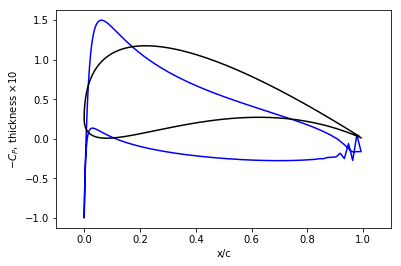

In [5]:
[cl,cp,xc,yc,dy,ds,theta,vt] = vortex_panel(points, 0, 1)
print(cl)
#print (theta)

In [6]:
def find_alpha(target_cl, points, guess):
    from scipy.optimize import minimize
    def fd_error(alpha, target_cl, points):
        [cl,cp,xc,yc,dy,ds,theta,vt] = vortex_panel(points, alpha, 0)
        a = (cl-target_cl)**2
        #print (a)
        #print (cl)
        return a
    alpha_pre = minimize(fd_error, guess, args=(target_cl, points), options = {'eps': 0.025})
    #[cl,cp,xc,yc,dy,ds,theta,vt] = vortex_panel(points, alpha, 0)
    alpha = alpha_pre.x
    a = alpha_pre.fun
    
    cl = ((a)**0.5) + target_cl
    
    
    return alpha, cl

Try running the function for $u^{(2)}_x=0.5$, your optimized $C_L A$ value from <code>lapsimulator.ipynb</code> and a wing area of $0.9\times0.4$. The lift of a 2D aerofoil is not the same as that for a 3D wing! Becasue a 3D wing has a fintie length, the lift is somewhat lower (depending on its length and shape). We'll simply assume $C_{L3D}$=$0.92 C_{L2D}$.

2.3387681159420284 [ 15.34141301] 2.3394237239617155


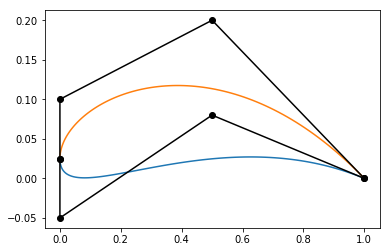

In [7]:
target_cl  =(0.7746 / (0.9 * 0.4)) /0.92
u2 = 0.5
guess = 5
points = parametric_aerofoil2(u2)
[alpha, cl] = find_alpha(target_cl, points, guess)
print(target_cl, alpha, cl)

In [8]:
"""find_alpha"""
assert np.allclose(find_alpha(target_cl, points, guess)[1],2.3388, 0.025)


The resultant angle of attack is very high! The flow would have stalled well below this angle, however, your race-car wing will have multiple elemts to achieve this $C_L$. For the remainder of this single-element example, we'll assume a required $C_L$ of 1.4.

In [9]:
target_cl = 1.4
u2 = 0.5 
guess = 5
[alpha, cl] = find_alpha(target_cl, points, guess)
print(alpha, cl)

[ 3.82947383] 1.4013619458073987


To minimize the drag, we'll need a way to simulate it! The function <code>viscous_solver(points,alpha,Re,nu,plotting)</code> is a quick-to-run simplified viscous boundary layer solver. It returns the lift and drag coefficients and pressure coefficient profile. The drag coefficient is not 'correct' (it underestimates) but takes into account the effects of the shape of the aerofoil and allows us to make comparisions between designs. The function is less accurate at high angles of attack where the flow separates (and gives a warning when separation is predicted). As for <code>vortex_panel</code>, the function requires a set of points along the surface of the aerofoil, the angle of attack and a 1 or 0 indicating whether you want outputs to be plotted. In addition, for the viscous calculation, the Reynolds number and kinematic viscosity are also required.

Lets assume a standard sea level kinematic visosity of air, a wing chord length of 0.4 m and a velocity of 20 m/s (that is, we'll design our aerofoil for just one velocity even though the car reaches many different speeds around the course). The drag calculation is then run as follows:

540540.5405405405
Lower surface transition at xc=0.47682725
Upper surface transition at xc=0.15803025
[ 1.39863805] 0.00850487383402


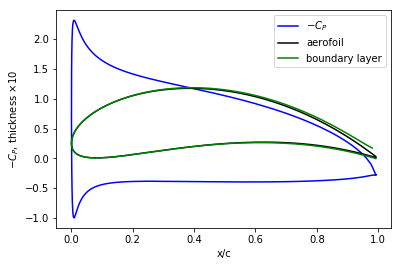

In [10]:
nu = 1.48e-5
c = 0.4
U = 20
Re = U * c / nu
print(Re)
points = parametric_aerofoil2(u2)
pl.clf()
plotting = 1
[cl,cd,cp] = viscous_solver(points, alpha, Re, nu, plotting)
print(cl, cd)

## Task 3: Invesitgate the effect of control point loaciton on aerofoil drag
Write a function that returns the lift to drag ratio and drag of an aerofoil for a given $u^{(2)}_x$ location, target lift coefficent, speed, and aerofoil chord length. The function returns the lift to drag ratio to mitigate any errors in the <code>find_alpha</code> function output. Use a kinematic viscosity of $\nu=1.48\times10^{−5}$ m$^2$/s.

In [11]:
def drag(u2, target_cl, U, c, plotting):
    nu = 1.48e-5
    Re = U * c / nu
    print(Re)
    points = parametric_aerofoil2(u2)
    alpha = find_alpha(target_cl, points, guess)[0]
    [cl,cd,cp] = viscous_solver(points, alpha, Re, nu, plotting)
    
    return cl/cd, cd


Try out your code:

540540.5405405405
Lower surface transition at xc=0.47682725
Upper surface transition at xc=0.15803025
[ 164.4513583] 0.00850487383402


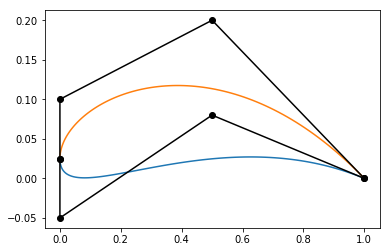

In [12]:
u2 = 0.5
target_cl = 1.4
U = 20
c = 0.4
plotting = 0
[clcd, cd]=drag(u2, target_cl, U, c, plotting)
print(clcd, cd)

In [13]:
"""Check drag"""
assert np.allclose(drag(u2,target_cl,U,c,plotting)[0],164.538, 0.5)
pl.clf()

540540.5405405405
Lower surface transition at xc=0.47682725
Upper surface transition at xc=0.15803025


Using the same methods as in lab three, create an array of seven values for the location of $u^{(2)}_x$: 0, 0.1,...0.6, find the correspnding lift to drag ratios and fit a moving least squares curve. Use the same lift, speed and chord as before. Find the lift to drag ratio predicted by this curve at $u^{(2)}_x=0.2$. In the cell below complete the <code>paramter_sweep</code> function:

In [14]:
u2_array = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

def parameter_sweep(u2_array):
    #from aclabtools import vortex_panel
    clcd_array = np.zeros(len(u2_array))
    for i in range(0, len(u2_array)):
        [clcd_array[i], cd]=drag(u2_array[i], target_cl, U, c, plotting)
    return clcd_array

Now run <code>paramter_sweep</code> and <code>mls_curve_fit</code> to find <code>pred_clcd</code> (the <code>mls_curve_fit</code> output at $u^{(2)}_x=0.2$):


(You may get a warning message: "The iteration is not making good progress..." when running <code>mls_curve_fit</code> - don't worry about this!)

540540.5405405405
Lower surface transition at xc=0.55669775
Upper surface transition at xc=0.0767975
540540.5405405405
Lower surface transition at xc=0.55669775
Upper surface transition at xc=0.08997665
540540.5405405405
Lower surface transition at xc=0.52967625
Upper surface transition at xc=0.105495
540540.5405405405
Lower surface transition at xc=0.51631025
Upper surface transition at xc=0.11792155
540540.5405405405
Lower surface transition at xc=0.48988275
Upper surface transition at xc=0.1501691
540540.5405405405
Lower surface transition at xc=0.47682725
Upper surface transition at xc=0.15803025
540540.5405405405
Lower surface transition at xc=0.45104775
Upper surface transition at xc=0.1814184


C:\Users\user\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


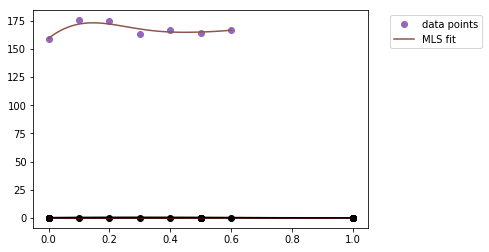

In [15]:
from aclabtools import mls_curve_fit
pl.clf()
pred_clcd = mls_curve_fit(u2_array, parameter_sweep(u2_array) , 0.2)

Print your result:

In [16]:
print(pred_clcd)

172.183392718


In [17]:
"""Check pred_clcd"""
assert np.allclose(pred_clcd,172.18, 1)

This assessed exercise is a hint of what you might do to find a good aerofoil shape for the elements of your race-car wing. The viscous solver is rather basic and will 'fall over' for some unusual geometries and extreme conditions. To further your 2D design you may wish to use find and use other tools such as Xfoil or Java foil, for example. You will then need to put the elements together and simulate your 3D wing in SolidWorks.

Make sure you save this .ipynb (and make sure it runs) before you submit it!